Some imports and data preparation to begin with:

In [1]:
pip install nlpaug transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import string
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw

import torch
from torch.utils.data import DataLoader
import transformers
from transformers import BertTokenizerFast
     

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_url = 'https://raw.githubusercontent.com/app1606/sentiment_test_task/main/fb_sentiment.csv'

data = pd.read_csv(data_url)[['FBPost','Label']]
data.head()


,FBPost,Label
0,Drug Runners and a U.S. Senator have somethin...,O
1,"Heres a single, to add, to Kindle. Just read t...",O
2,If you tire of Non-Fiction.. Check out http://...,O
3,Ghost of Round Island is supposedly nonfiction.,O
4,Why is Barnes and Nobles version of the Kindle...,N


In [4]:
lemmatizer = WordNetLemmatizer()
vocab_size = 0

def preprocess(text):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    text = re.sub(r'#', '', text)
    text = str(re.sub("\S*\d\S*", "", text).strip())
    # tokenize texts
    
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tokens = tokenizer.tokenize(text)
    texts_clean = []
    
    for word in tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation+'...'):  # remove punctuation
            # 
            stem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(stem_word)

    return " ".join(texts_clean)

In [5]:
preprocess(data['FBPost'].loc[1])

'heres single add kindle read century story ghost round island man french american indian dog sled transport woman across ice mackinac island cheboygan ghost'

In [6]:
data['Label']=data['Label'].apply(lambda x: 2 if (x=='P')  else 0 if (x == 'N') else 1) #put the labels to the comments

In [7]:
aug = naw.SynonymAug(aug_src='wordnet') # simple synonym augmentation

2    641
1    280
0     79
Name: Label, dtype: int64


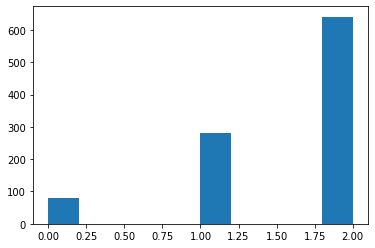

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(data['Label'].value_counts())
data['Label'].hist(grid=False)
plt.show()

Here is the code for the augmentation. I decided to make twice more examples of the negative(0) and neutral(1) classes since most of the comments are positive. 

In [9]:
augmented_sentences = []
augmented_sentences_labels = []

for i in data['FBPost'].index: #augment full sentence before preprocessing 
    if data['Label'][i] < 2: #finding the balance
        num_ex = 5
    else:
        num_ex = 10

    augmentized = aug.augment(data['FBPost'][i], n=num_ex) 

    for sent in augmentized:
      augmented_sentences.append(preprocess(sent))
      
      augmented_sentences_labels.append(data['Label'][i])

In [10]:
data['FBPost'] = data['FBPost'].apply(lambda x: preprocess(str(x))) #preprocess dataset

In [11]:
data.head()

,FBPost,Label
0,drug runners u senator something murder,1
1,heres single add kindle read century story gho...,1
2,tire non-fiction check,1
3,ghost round island supposedly nonfiction,1
4,barnes nobles version kindle much expensive ki...,0


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() #use vectorizer to create vocabulary
inputs = list(data['FBPost']) + augmented_sentences  
vectorizer.fit(inputs)

CountVectorizer()

In [13]:
with open('vocab.txt', 'w') as f: #create vocabulary for tokenizer
    f.write('''[PAD]\n[UNK]\n[CLS]\n[SEP]\n[MASK]\n''') #add tokens for tokenizer
    for s in vectorizer.vocabulary_:
        f.write(s + '\n')

In [14]:
pad_token_idx = 0 #token indices in vocabulary
sep_token_idx = 3

In [15]:
tokenizer = BertTokenizerFast('./vocab.txt', special_tokens=None) 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['FBPost'], data['Label'], test_size=0.2)

Let's check the length of the comments. This statistic will be handy because we can cut the text by the beginning and make the decision based on the first $mean\_length$ words. 

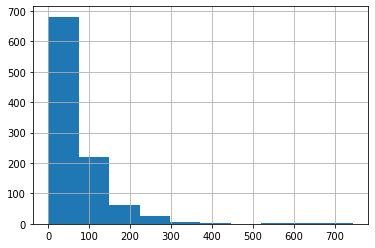

count    1000.000000
mean       66.706000
std        71.358374
min         0.000000
25%        23.000000
50%        45.000000
75%        88.000000
max       744.000000
dtype: float64

In [17]:
comment_length = [len(x) for x in data['FBPost']]

pd.Series(comment_length).hist()
plt.show()
pd.Series(comment_length).describe() 

In [18]:
X_train = X_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train = y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)

(9005,)
(9005,)


<ipython-input-18-d6f89e10ea9c>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(pd.Series(augmented_sentences),ignore_index=True)
<ipython-input-18-d6f89e10ea9c>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)


In [19]:
class TextDataset(torch.utils.data.Dataset): #simple dataset class 
    def __init__(self, posts, labels=None):
        self.posts = [tokenizer.encode(post, add_special_tokens=False) for post in posts.values if post != '']
        self.labels = labels.values

    def __getitem__(self, idx):
        return self.posts[idx], self.labels[idx]

    def __len__(self):
        return len(self.posts)

In [20]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch): #function that pads the sentence with tokens if it is too short
    src_list = []
    lab_list = []
    for src in batch: 
        src_list.append(torch.tensor(src[0])[:70]) #cut by mean length 
        lab_list.append(torch.tensor(src[1]))
    
    return [pad_sequence(src_list, padding_value=pad_token_idx, batch_first=True), torch.tensor(lab_list)]

In [21]:
train_data = TextDataset(X_train, y_train)
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)

In [22]:
test_data = TextDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size, collate_fn=collate_batch)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

I decided to go with the LSTM network because the are not much data to train. There is no Softmax layer here because I use CrossEntropyLoss, which has it inside.  


Even with that my network quickly started overfitting no matter what the parameters were, but this will be described in the conclusion. 

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class RnnGenerator(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hid_dim, num_layers, num_classes):
        super().__init__()

        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hid_dim, num_layers, dropout=0.5, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(hid_dim, num_classes)

    def forward(self, x):
        inds = ((x > 0) + 0).argmin(dim=1, keepdim=True) #where the sentence ends, ignore padding
        inds[inds == 0] = -1 

        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)

        pred = self.out(self.dropout(output).squeeze(dim=0))

        result = torch.zeros((x.shape[0], pred.shape[-1]))

        for i in range(x.shape[0]): #select the (future) logits
            result[i] = pred[i][inds[i]]
        
        return result

In [25]:
vocab_size = len(vectorizer.vocabulary_) + 5
print(vocab_size)
model = RnnGenerator(vocab_size, 300, 256, 2, 3)


5533


The actual output looks like that (each batch has three class "logits" of ):

In [26]:
batch = next(iter(train_dataloader))
x = batch[0][:3]
res = model(x)
res = model(x)
res

tensor([[-3.1791e-02,  3.5730e-02, -1.1014e-02],
        [-5.7026e-02,  1.6819e-02,  5.5498e-03],
        [ 6.2451e-05,  6.6570e-02, -4.6882e-02]], grad_fn=<CopySlices>)

In [27]:
model.to(device)

RnnGenerator(
  (embedding): Embedding(5533, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=256, out_features=3, bias=True)
)

In [28]:
learning_rate = 0.0005
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [29]:
criterion = torch.nn.CrossEntropyLoss()

Model evaluation: check for actual loss and accuracy on the test (i also added train check to compare the accuracy)

In [30]:
def eval_model(model):
    model.eval()
    losses = []
    correct = 0
    sum_num = 0

    for batch in test_dataloader:
        src = batch[0].int().to(device) #input and goal
        trg = batch[1].to(device)

        with torch.no_grad():  
            logits = model(src).to(device) #result
            loss = criterion(logits, trg)
            correct += (logits.argmax(dim=-1) == trg).sum() #accuracy
            sum_num += trg.shape[0] 

        losses.append(loss.item())

    acc = correct / sum_num
    return np.mean(losses), float(acc)

In [31]:
def eval_model_train(model):
    model.eval()
    losses = []
    correct = 0
    sum_num = 0

    for batch in train_dataloader:
        src = batch[0].int().to(device)
        trg = batch[1].to(device)
       
        with torch.no_grad():  
            logits = model(src).to(device)
            loss = criterion(logits, trg)
            correct += (logits.argmax(dim=-1) == trg).sum()
            sum_num += trg.shape[0]

        losses.append(loss.item())

    acc = correct / sum_num
    return np.mean(losses), float(acc)

In [32]:
eval_model(model)

(1.0983902897153581, 0.29441624879837036)

In [33]:
def train_epoch(model, callback):
    model.train()
    losses = []
    n_iter = 0

    for batch in tqdm(train_dataloader):
        src = batch[0].to(device)
        trg = batch[1].to(device)  

        prediction = model(src).to(device)
        loss = criterion(prediction, trg)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        losses.append(loss.item())


        n_iter += 1
        if n_iter % 100 == 0:
            callback(np.mean(losses))
            losses = []

In [34]:
from tqdm.notebook import tqdm, trange

def callback(train_loss):
    eval_loss, eval_acc = eval_model(model)
    model.train()
    print(f'Epoch: {epoch+1:02} | train_loss = {train_loss:.5f}, eval_loss = {eval_loss:.5f}, eval_acc = {eval_acc:.5f}')

for epoch in trange(10):
    train_loss = train_epoch(model, callback)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 01 | train_loss = 0.69012, eval_loss = 1.15007, eval_acc = 0.61421
Epoch: 01 | train_loss = 0.64622, eval_loss = 1.13633, eval_acc = 0.60914


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 02 | train_loss = 0.54296, eval_loss = 1.35776, eval_acc = 0.57868
Epoch: 02 | train_loss = 0.51626, eval_loss = 1.36987, eval_acc = 0.56853


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 03 | train_loss = 0.38928, eval_loss = 1.55726, eval_acc = 0.53299
Epoch: 03 | train_loss = 0.42228, eval_loss = 1.63176, eval_acc = 0.55838


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 04 | train_loss = 0.33603, eval_loss = 1.84331, eval_acc = 0.51777
Epoch: 04 | train_loss = 0.32291, eval_loss = 1.79749, eval_acc = 0.52792


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 05 | train_loss = 0.24519, eval_loss = 1.96224, eval_acc = 0.55838
Epoch: 05 | train_loss = 0.28716, eval_loss = 2.14434, eval_acc = 0.54315


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 06 | train_loss = 0.21194, eval_loss = 2.25533, eval_acc = 0.51269
Epoch: 06 | train_loss = 0.22699, eval_loss = 2.35254, eval_acc = 0.55330


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 07 | train_loss = 0.16555, eval_loss = 2.34426, eval_acc = 0.55330
Epoch: 07 | train_loss = 0.19382, eval_loss = 2.60382, eval_acc = 0.53807


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 08 | train_loss = 0.13621, eval_loss = 2.94723, eval_acc = 0.50761
Epoch: 08 | train_loss = 0.16538, eval_loss = 2.66924, eval_acc = 0.54315


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 09 | train_loss = 0.13085, eval_loss = 2.88951, eval_acc = 0.52284
Epoch: 09 | train_loss = 0.14199, eval_loss = 2.97170, eval_acc = 0.55330


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch: 10 | train_loss = 0.11412, eval_loss = 3.26496, eval_acc = 0.55330
Epoch: 10 | train_loss = 0.12778, eval_loss = 2.84378, eval_acc = 0.54822


In [35]:
eval_model(model)

(2.894496168409075, 0.5329949259757996)

In [36]:
eval_model_train(model)

(0.09281617710168691, 0.964083194732666)

We can see a huge difference between the accuracy and loss at train and test. I made  experiments with various LSTM models (from 1 layer and smaller hidden and embedding dimensions to multi-layer and bigger dimensions), but all of them were prone to overfitting. 

It seems that the problem is in the size of the dataset (even with the augmentation), the model is bigger and overfits easier. Probably, some other models could be used here for better performance.  